In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
import sklearn.preprocessing


In [5]:
train_file = "../data/train.csv"
test_file = "../data/test.csv"


train_data_raw = pd.read_csv(train_file)
test_data_raw = pd.read_csv(test_file)

target = "Survived"


In [6]:

### CLEAN DATA FUNC

def clean_func(train_data):
    
    ## DO IMPUTATION 
    # FARE
    imp_fare = Imputer(missing_values="NaN", strategy="mean")
    imp_fare.fit(train_data[["Fare"]])
    train_data[["Fare"]]=imp_fare.transform(train_data[["Fare"]]).ravel() 

    # Age
    imp=Imputer(missing_values="NaN", strategy="mean")
    imp.fit(train_data[["Age"]])
    train_data[["Age"]]=imp.transform(train_data[["Age"]]).ravel() 
    
    # Filna
    train_data["Cabin"] = train_data["Cabin"].fillna("")

    
    # one hot encoding
    sex_features = pd.get_dummies(train_data["Sex"])
    embarked_features = pd.get_dummies(train_data["Embarked"])
    
    # rename embarked features
    embarked_features = embarked_features.rename(columns={'C': 'embarked_cobh'
                                                        , 'Q': 'embark_queenstown'
                                                        , 'S': 'embark_southampton'})

    # Concat new features
    train_data_extras = pd.concat([train_data,sex_features,embarked_features],axis=1)

    
    
    # HACK - REMOVE T WHICH IS NOT IN TEST LIKELY ERRROR 
    cabin_letters = pd.get_dummies(train_data['Cabin'].map(lambda x: "empty" if len(x)==0 or x[0]=="T" else x[0]))

#    cabin_letters = pd.get_dummies(train_data['Cabin'].map(lambda x: "empty" if len(x)==0 else x[0]))
    cabin_letters.columns = ["Cabin_letter_"+i for i in cabin_letters.columns]
    train_data_extras = pd.concat([train_data_extras,cabin_letters],axis=1)
    

    train_data_extras["Cabin_number"] = train_data['Cabin'].map(lambda x: -99 if len(x)==0 else x.split(" ")[0][1:]) 

    # ONLY RETURN NUMERIC COLUMNS 
    num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']
    train_data_numerics = train_data_extras.select_dtypes(include=num_types)

    return train_data_numerics


## Select only numeric columns

In [7]:
train_data_raw2 = clean_func(train_data_raw)
train_data = train_data_raw2.iloc[:, train_data_raw2.columns != target]
train_data_target = train_data_raw2[target].values


/Users/emil/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/emil/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(train_data
                              ,train_data_target
                              ,test_size=0.3
                              ,random_state=42)

# Models
- logreg
- random forest

### random forest naive

In [9]:
model_rf = RandomForestClassifier(
n_estimators=100
)

model_rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
# Cross Validation RF

scores = cross_val_score(model_rf, X_train, Y_train, cv=10)
print(scores)

[0.84375    0.80952381 0.88709677 0.82258065 0.79032258 0.75806452
 0.82258065 0.77419355 0.82258065 0.91935484]


In [11]:
pred_rf = model_rf.predict(X_test)
metrics.accuracy_score(Y_test,pred_rf)

0.8097014925373134

### Random Forest Grid Search

In [12]:
model_rf_gs = RandomForestClassifier()



In [13]:
# parmeter dict
param_grid = dict(
    n_estimators=np.arange(60,101,20)
    , min_samples_leaf=np.arange(2,4,1)
    #, criterion = ["gini","entropy"]
    #, max_features = np.arange(0.1,0.5,0.1)
)
print(param_grid)

{'n_estimators': array([ 60,  80, 100]), 'min_samples_leaf': array([2, 3])}


In [21]:
grid = GridSearchCV(model_rf_gs,param_grid=param_grid,scoring = "accuracy", cv = 5)
grid.fit(train_data, train_data_target)
""

# model_rf.fit(train_data, train_data[target])

''

In [17]:
# print(grid)
# for i in ['params',"mean_train_score","mean_test_score"]:
#     print(i)
#     print(grid.cv_results_[i])
# grid.cv_results_

In [16]:
print(grid.best_params_)
print(grid.best_score_)


{'min_samples_leaf': 3, 'n_estimators': 60}
0.8237934904601572


In [23]:
model_rf_gs_best =  RandomForestClassifier(**grid.best_params_)
model_rf_gs_best.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
## print feture importance
model = model_rf_gs_best
feature_names = X_train.columns.values
feature_importance2 = sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), feature_names), reverse=True)

print(len(feature_importance2))

for feature in feature_importance2:
    print('%f:%s' % feature )

19
0.175900:male
0.171100:female
0.153000:Fare
0.127200:Age
0.110800:PassengerId
0.073200:Pclass
0.043100:Cabin_letter_empty
0.039600:SibSp
0.028100:Parch
0.019300:embarked_cobh
0.015800:embark_southampton
0.012300:Cabin_letter_E
0.008100:Cabin_letter_B
0.006000:embark_queenstown
0.005100:Cabin_letter_D
0.004900:Cabin_letter_C
0.003800:Cabin_letter_F
0.001600:Cabin_letter_A
0.001100:Cabin_letter_G


In [30]:
### 
# Recursive feature elimination
from sklearn.feature_selection import RFECV

model = model_rf_gs_best

rfecv = RFECV(estimator=model, step=1, cv=3, scoring='accuracy')

rfecv.fit(X_train,Y_train)


RFECV(cv=3,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

Optimal number of features : 16
== Feature short list ==
['PassengerId' 'Pclass' 'Age' 'SibSp' 'Parch' 'Fare' 'female' 'male'
 'embarked_cobh' 'embark_queenstown' 'embark_southampton' 'Cabin_letter_B'
 'Cabin_letter_C' 'Cabin_letter_D' 'Cabin_letter_E' 'Cabin_letter_empty']


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

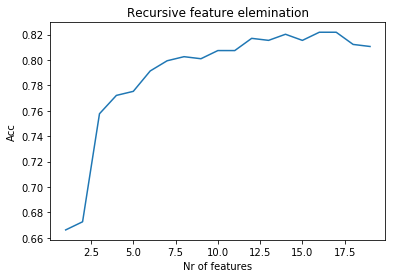

In [37]:
import matplotlib.pyplot as plt
from sklearn import base

model = model_rf_gs_best

print("Optimal number of features : %d" % rfecv.n_features_)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title('Recursive feature elemination')
plt.xlabel('Nr of features')
plt.ylabel('Acc')

feature_short = feature_names[rfecv.support_]
print('== Feature short list ==')
print(feature_short)

model_simple = base.clone(model)
model_simple.fit(X_train[feature_short],Y_train)



- Converge about 16
- let us comare 16 vs full features on test set

In [43]:

Y_pred = model.predict(X_test)
model_score = metrics.accuracy_score(Y_test,Y_pred)

Y_pred_simple = model_simple.predict(X_test[feature_short])
model_simple_score = metrics.accuracy_score(Y_test,Y_pred_simple)

print("model acc: %.3f" % model_score)
print("simple model acc: %.3f" % model_simple_score)

model acc: 0.806
simple model acc: 0.825


ie. we sligtly increase test scores by removing extra variables with recursive feature elimination. (ie we remove extra variable that only seem to overfit on noise and don't contribute to acc)

Often an even more conservative cutoff can be used and go for 90% of max accurracy to remove variables with little to no signal.